In [2]:
import numpy as np
import mne

In [3]:
import umap

/home/huang/anaconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
microstate_maps = np.load("./data/microstate_maps.npy")

In [5]:
eeg_raw = mne.io.read_raw('./data/Raw_EDF_Files/p10_Record1.edf') #list(eeg_raw.values())[0]

Extracting EDF parameters from /home/huang/research/snn-seizure-prediction-research/data/Raw_EDF_Files/p10_Record1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [6]:
SOP = 20 * 60 # seizure occurrance period (s)
SPH = 5 * 60 # seizure prediction horizon

In [7]:
freq = 500
total_length = freq * SOP

In [8]:
data = eeg_raw.get_data().T

In [81]:
# Clip the data. (Extract the seizure occurrance period)

record_start = (5, 36, 39) # hour, minute, seconds.

seizure1 = (7, 36, 38)  # hour, minute, seconds.
seizure1_start = ((seizure1[0] - record_start[0]) * 3600 + (seizure1[1] - record_start[1]) * 60 + (seizure1[2] - record_start[2])) * freq
seizure1_length = (60 * 7 + 25) * freq
seizure1_end = seizure1_start + seizure1_length

# clip
seizure_mid = (seizure1_start + seizure1_end) // 2
clip_left = (seizure_mid - total_length // 2)
clip_right = (seizure_mid + total_length // 2)
additional_offset = 0

# Right moving the fragment, if `clip_left` < 0 (seizure happens < 15 minute from the beginning of record.). 
# This operation aims at making prediction area as large as possible.
if (clip_left < 0):
    max_movable_length = seizure1_end - seizure_mid + (seizure1_length // 2)
    additional_offset = min(abs(clip_left), max_movable_length)
    clip_left += additional_offset
    clip_right += additional_offset
    
train_data = data[clip_left: clip_right, :]
seizure_offset = (total_length // 2) - ((seizure1_end - seizure1_start) // 2) + additional_offset

In [9]:
a = (train_data.dot(microstate_maps.T)) ** 2
microstate_sequence = np.argmax(a, axis = 1)
del train_data

In [10]:
del data

In [83]:
states = []

m = 50
for i in range(m, len(train_data[:,0])):
    states.append(train_data[i - m: i, 0])

In [86]:
states = np.array(states)


In [11]:
states = []
m = 50
for i in range(m, len(microstate_sequence)):
    states.append(microstate_sequence[i - m: i])

In [12]:
states = np.array(states)
states

array([[1, 1, 3, ..., 3, 3, 3],
       [1, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]])

In [13]:
from sklearn.manifold import TSNE, Isomap, SpectralEmbedding


In [14]:
embedding = Isomap(n_components=3)

In [15]:
embedding = TSNE(n_components=3, learning_rate = 'auto', init='random')

In [16]:
embedding = SpectralEmbedding(n_components=3)

In [87]:
embedding = umap.UMAP(n_components=2)


In [88]:
states_transformed = embedding.fit_transform(states)

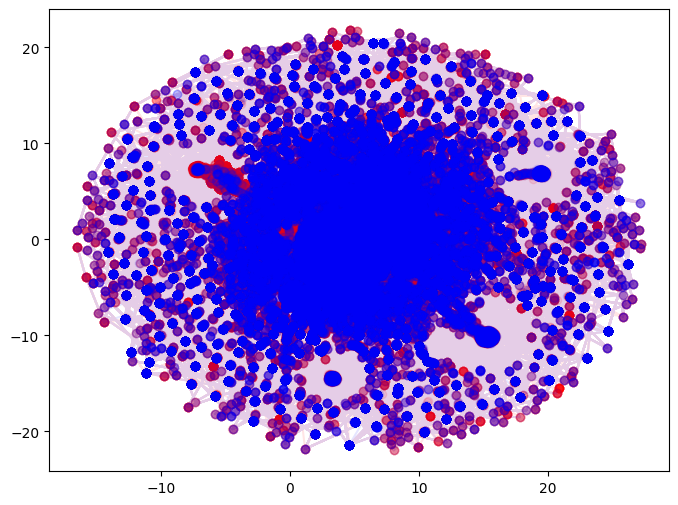

In [74]:

plt.figure(figsize=(8, 6))

onset_zone = states_transformed[seizure_offset: seizure_offset + seizure1_length]
pre_epileptic_zone = states_transformed[seizure_offset - 100000: seizure_offset]
post_epileptic_zone = states_transformed[seizure_offset + seizure1_length: seizure_offset + seizure1_length + 100000]

plt.plot(onset_zone[:, 0], onset_zone[:, 1], marker='o', linestyle='-', color='red', label='Trajectory1', alpha=0.1)
plt.plot(pre_epileptic_zone[:, 0], pre_epileptic_zone[:, 1], marker='o', linestyle='-', color='blue', label='Trajectory2', alpha=0.1)
#plt.plot(post_epileptic_zone[:, 0], post_epileptic_zone[:, 1], marker='o', linestyle='-', color='green', label='Trajectory', alpha=0.1)


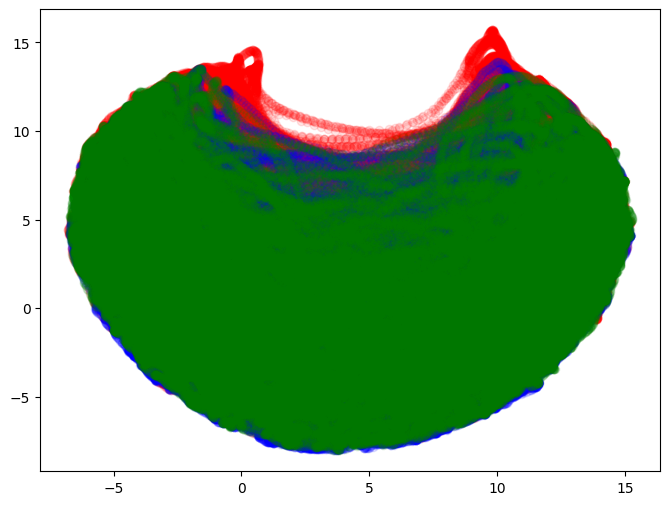

In [98]:

plt.figure(figsize=(8, 6))

onset_zone = states_transformed[seizure_offset: seizure_offset + seizure1_length]
pre_epileptic_zone = states_transformed[seizure_offset - 100000: seizure_offset]
post_epileptic_zone = states_transformed[seizure_offset + seizure1_length: seizure_offset + seizure1_length + 100000]

plt.plot(onset_zone[:, 0], onset_zone[:, 1], marker='o', linestyle='-', color='red', label='Trajectory1', alpha=0.1)
plt.plot(pre_epileptic_zone[:, 0], pre_epileptic_zone[:, 1], marker='o', linestyle='-', color='blue', label='Trajectory2', alpha=0.1)
plt.plot(post_epileptic_zone[:, 0], post_epileptic_zone[:, 1], marker='o', linestyle='-', color='green', label='Trajectory', alpha=0.1)


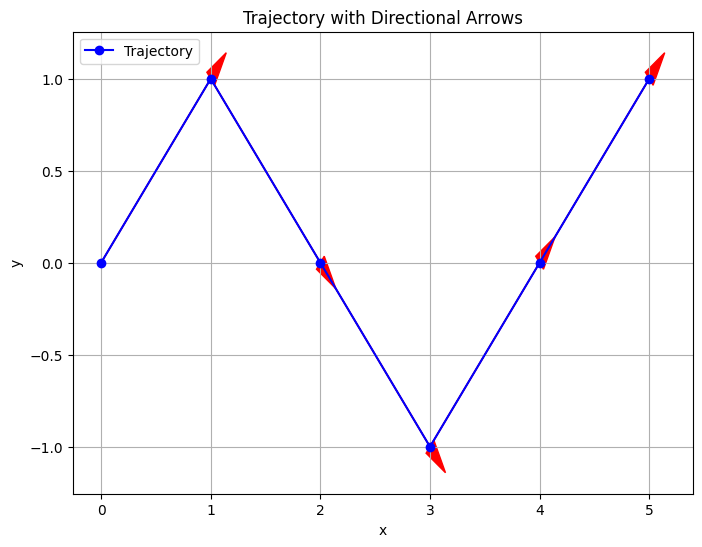

In [5]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6))
plt.plot(x, y, marker='o', linestyle='-', color='b', label='Trajectory')

# Add directional arrows
for i in range(len(x) - 1):
    plt.arrow(x[i], y[i], x[i+1] - x[i], y[i+1] - y[i],
              head_width=0.1, head_length=0.2, fc='r', ec='r')

plt.title('Trajectory with Directional Arrows')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.show()

/tmp/ipykernel_32045/1313311698.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


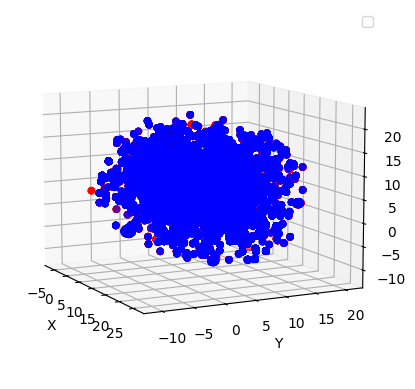

In [61]:
import matplotlib.pyplot as plt
import numpy as np

ax = plt.figure().add_subplot(projection='3d')

# Plot scatterplot data (20 2D points per colour) on the x and z axes.
colors = ('r', 'g', 'b', 'k')

onset_zone = states_transformed[seizure_offset: seizure_offset + seizure1_length]
pre_epileptic_zone = states_transformed[seizure_offset - 100000: seizure_offset]
post_epileptic_zone = states_transformed[seizure_offset + seizure1_length: seizure_offset + seizure1_length + 100000]
ax.scatter(xs=onset_zone[:, 0], ys = onset_zone[:, 1], zs=onset_zone[:, 2], c="red")
ax.scatter(xs=pre_epileptic_zone[:, 0], ys = pre_epileptic_zone[:, 1], zs=pre_epileptic_zone[:, 2],  c="blue")
#ax.scatter(xs=post_epileptic_zone[:, 0], ys = post_epileptic_zone[:, 1], zs=post_epileptic_zone[:, 2], c="green")

ax.legend()

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Customize the view angle so it's easier to see that the scatter points lie
# on the plane y=0
ax.view_init(elev=10., azim=-27, roll=0)

plt.show()

In [49]:
len(states_transformed[seizure_offset: seizure_offset + seizure1_length])

222500

In [31]:
len(states_transformed)

599950